## Imports

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
import math
from sklearn.linear_model import LinearRegression

## Load Dataset

In [33]:
train_data = pd.read_csv('Dataset/train.csv')

submission_data = pd.read_csv('Dataset/test.csv')

## Exploratory Data Analysis

In [34]:
print('Shape of train data: ', train_data.shape)

Shape of train data:  (891, 12)


In [35]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Visualize Data

### Fare

[]

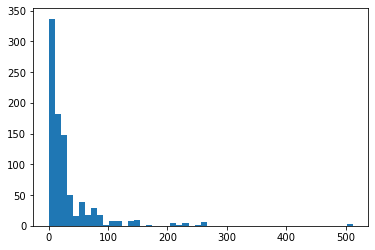

In [36]:
plt.hist(train_data["Fare"], bins=50)
plt.plot()

### Embarked

[]

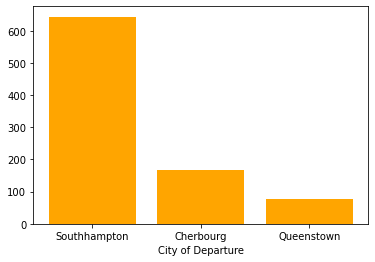

In [37]:
data = train_data["Embarked"].value_counts()
labels = ["Southhampton", "Cherbourg", "Queenstown"]
plt.xticks(range(len(labels)),labels)
plt.xlabel("City of Departure")
plt.bar(range(len(data)), data, color="orange")
plt.plot()

### Age

[]

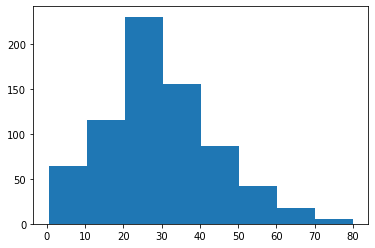

In [38]:
plt.hist(train_data["Age"],bins=8)
plt.plot()

### Gender

[]

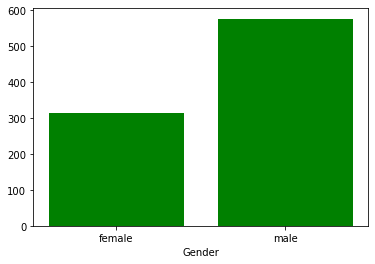

In [39]:
female_passengers = len(train_data[train_data["Sex"]=="female"])
male_passengers = len(train_data[train_data["Sex"]=="male"])
data = [female_passengers,male_passengers]
labels = ["female", "male"]
plt.xticks(range(len(labels)),labels)
plt.xlabel("Gender")
plt.bar(range(len(data)), data, color="green")
plt.plot()

### Passenger Classes

[]

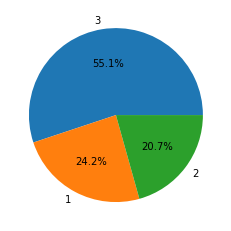

In [40]:
data = train_data["Pclass"].value_counts()

labels = [3,1,2]
#plt.yticks(range(len(labels)),labels)
#plt.ylabel("Passenger class")
plt.pie(x=data, labels=labels, autopct='%1.1f%%')
plt.plot()

### Survived

[]

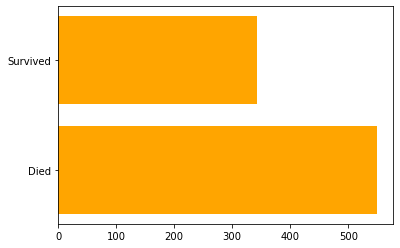

In [41]:
data = train_data["Survived"].value_counts(sort=False)

labels = ["Died", "Survived"]
plt.yticks(range(len(labels)),labels)
plt.barh(range(len(data)), data, color="orange")
plt.plot()

In [42]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


As we can see, some columns contain virtually no null values while others (e.g. Cabin) contain a large number of null-values.
Let's have a look at the survival rates by look at each category individually.

In [43]:
def plot_survivalRateByCategory(data,colnames):
    fig, ax = plt.subplots(len(colnames), figsize=(8,10), constrained_layout=True)
    # iterate through colnames
    for idx,colname in enumerate(colnames):
        # get mean and std dev for survival rates per category
        survivalByCategory = data.groupby([colname])['Survived'].describe()
        # number of differen categories
        n_category = survivalByCategory.shape[0]
        # plot one std dev confidence (confidence is capped between 0 and 1)
        for i in range(n_category):
            ax[idx].plot([i,i],
                         np.minimum(np.maximum(survivalByCategory['mean'].iloc[i]+np.array([-1,1])*survivalByCategory['std'].iloc[i],0),1),
                         'b');
        # plot survival rate
        ax[idx].plot(range(n_category),survivalByCategory['mean'],'bo', markersize=12);
        plt.sca(ax[idx])
        plt.xticks(np.array([-0.4]+ list(range(n_category)) + [n_category-1+.4]),
                   ['']+list(survivalByCategory.index)+['']);
        plt.yticks(np.arange(0,1.1,0.2),['']+[str(np.int8(s))+'%' for s in np.arange(.2,1.1,0.2)*100]);
        plt.title('Survival Rate By {0}'.format(colname), size=16);
    plt.show()

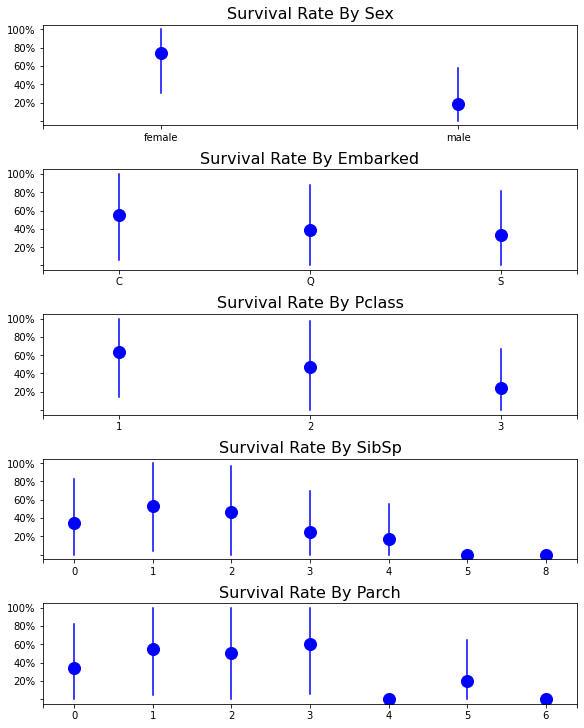

In [44]:
plot_survivalRateByCategory(train_data,['Sex','Embarked','Pclass','SibSp','Parch'])

We can see some expected relations and others which one might not expect. First of all, it is clear to see that the survival rate of females was significantly higher than the survival rate of males. In addition, a higher class correlates with a lower chance of survival. Both of these relations might not be so unexpected. However, that the survival rate of passengers who embarked at Cherbourg is so much higher than the survival rate of passengers who embarked at Southampton might not have been anticipated by everyone. This can be explained rather easily: The people who embarked in Cherbourg were mostly members of the social elite such as [Lucile Duff-Gordon and John Jacob Astor IV.][http://www.titanic-stories.de/pages/route.html]

Now let's have a look a the continuous variables given.

In [45]:
def plot_survivalRateByContinousVar(data,colnames):
    fig, ax = plt.subplots(len(colnames), figsize=(8,10), constrained_layout=True)
    # iterate through colnames
    for idx,colname in enumerate(colnames):
        # plot scatter dots
        ax[idx].scatter(train_data[colname],train_data['Survived'])
        # plot means for survived and died
        ax[idx].scatter(train_data.groupby(['Survived'])[colname].mean(),[0,1],c='red')
        plt.sca(ax[idx])
        plt.title('Scatterplot for {0}'.format(colname), size=16)
        plt.yticks([-.1,0,1,1.1],['','Died','Survived',''])
        plt.xlabel(colname)
    plt.show()

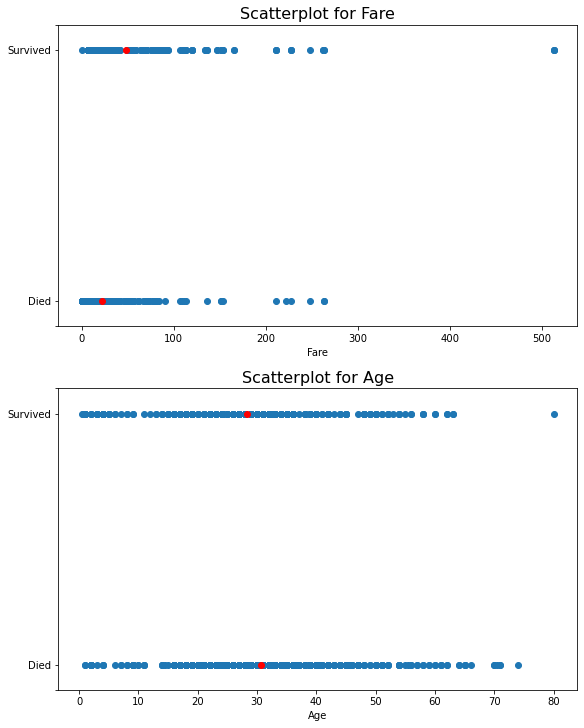

In [46]:
plot_survivalRateByContinousVar(train_data,['Fare','Age'])

This plot reveals that people who payed more for their ticket had a higher chance of survival. It also seems like the people who survived were a little younger than those who died although the difference here is minor.

In [47]:
print('Correlation Matrix:')
corr = train_data.corr()
corr.style.background_gradient(cmap='coolwarm')

Correlation Matrix:


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [48]:
corr_survived = corr["Survived"]
corr_survived

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

Here we can see that a passenger's class and his fare were the best predictors for his/her survival (when looking at the numerical columns only).

## Data Preprocessing

### Remove uninformative rows 

In [49]:
train_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


Obviously passengerid and name can be dropped. We additionally decided to drop the column ticket because the were so many different names and the fare of a ticket somewhat represents the type of ticket that a person bought. We also dropped the column Cabin because it is uninformative in our opinion, especially because it contains so many NaN values.

In [50]:
# drop columns from both train and test sample
train_data.drop(['PassengerId','Name','Ticket','Cabin'], axis=1, inplace=True)
submission_data.drop(['PassengerId','Name','Ticket','Cabin'], axis=1, inplace=True)

### Handling NaNs
First we count how many NaN entries we have for each column.

In [51]:
train_data.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

For now we will just replace the missing age with its mean and drop the two rows where "embarked" is missing

In [52]:
train_data.loc[train_data['Age'].isna(),'Age'] = train_data['Age'].mean()
train_data.dropna(inplace=True)

Double check if there are any NaN values left

In [53]:
train_data.isnull().isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

### Prepare data for modeling
We will label-encode the sex column first and later use one-hot encoding for the embarked column

In [54]:
train_data['Sex'].replace({'male':0, 'female':1}, inplace=True)
submission_data['Sex'].replace({'male':0, 'female':1}, inplace=True)

In [55]:
train_data = pd.get_dummies(train_data)
submission_data = pd.get_dummies(submission_data)
train_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,3,0,22.000000,1,0,7.2500,0,0,1
1,1,1,1,38.000000,1,0,71.2833,1,0,0
2,1,3,1,26.000000,0,0,7.9250,0,0,1
3,1,1,1,35.000000,1,0,53.1000,0,0,1
4,0,3,0,35.000000,0,0,8.0500,0,0,1
...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.000000,0,0,13.0000,0,0,1
887,1,1,1,19.000000,0,0,30.0000,0,0,1
888,0,3,1,29.699118,1,2,23.4500,0,0,1
889,1,1,0,26.000000,0,0,30.0000,1,0,0


Now we have all our columns in the right format

In [56]:
y_full = train_data["Survived"]
X_full = train_data.drop("Survived",axis=1)

### Train test split

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, stratify=y_full, random_state=538974
)

### Handling outliers
Isolation forests detect outliers based on topology. If we have only very few splits for some observations in many ensemble trees the observations of this leaf is very likely to be an outlier. Now let's get into it:

Let's say just one 2% of the data are outliers

In [58]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.02).fit(pd.concat([y_train,X_train], axis=1))
outlier_idx = iso_forest.predict(pd.concat([y_train,X_train], axis=1))==-1

Now let's remove the outliers...

In [59]:
tmp_idx = np.logical_not(outlier_idx)
X_clean_train, y_clean_train = X_train.iloc[tmp_idx,:], y_train[tmp_idx]

And double check

In [60]:
X_clean_train.shape, X_train.shape

((652, 9), (666, 9))

## Train the model(s)

In [61]:
# write function that predicts with and without outliers
def outlierDropPerformance(clf, X_train, X_train_clean, X_test, y_train, y_train_clean, y_test, round_acc=7):
    # fit for complete data
    clf.fit(X_train,y_train)
    # predict
    pred = clf.predict(X_test)
    # accuracy
    acc = accuracy_score(y_test, np.round(pred))
    print('Accuracy for complete data: ' + str(np.round(acc, round_acc)))
    
    # fit with removed outliers
    clf.fit(X_train_clean,y_train_clean)
    # predict
    pred_rmOutlier = clf.predict(X_test)
    # accuracy
    acc_rmOutlier = accuracy_score(y_test, np.round(pred_rmOutlier))
    print('Accuracy with removed outliers: ' + str(np.round(acc_rmOutlier, round_acc)))
    
    return pred, pred_rmOutlier

### 1. Random Forest
With random forests we can use the full dataset because bootstrap samples include in mean only 66% of the data in one tree. With the remaining (called out-of-bag) we predict the accuracy. Unfortunatley the OOB score can not be compared to other accuracy scores, that's why we decided to also perform the train test accuracy.

In [62]:
rf = RandomForestRegressor(n_estimators = 200, random_state = 42)

# compare models and outlier drop performace
pred_rf, pred_rf_rmOutl = outlierDropPerformance(rf,X_train, X_clean_train, X_test, 
                                                 y_train, y_clean_train, y_test)

Accuracy for complete data: 0.7892377
Accuracy with removed outliers: 0.8026906


### 2. XGBoost

In [63]:
xgb = XGBClassifier(use_label_encoder=False,
                    eval_metric='logloss')

# compare models and outlier drop performace
pred_xgb, pred_xgb_rmOutl = outlierDropPerformance(xgb,X_train, X_clean_train, X_test, 
                                                   y_train, y_clean_train, y_test)

Now we will use grid search to hopefully find parameter values with a better accuracy

In [ ]:
# set potential parameters

parameters = {'eta':[.1,.2,.3],         # learning rate/ step size
              'max_depth':[4,6],      # max depth of sub tree
              'reg_lambda':[.5,1,2,10], # l2 regularization
              'reg_alpha':[0,.5,1,10]}  # l1 regularization
clf = GridSearchCV(xgb, parameters)

In [ ]:
clf.fit(X_train,y_train)

{'eta': 0.1, 'max_depth': 4, 'reg_alpha': 1, 'reg_lambda': 10}

In [ ]:
clf.best_params_

{'eta': 0.1, 'max_depth': 4, 'reg_alpha': 1, 'reg_lambda': 10}

In [ ]:
# Init classifier
xgb_param_opt = XGBClassifier(eta=clf.best_params_['eta'],
                              eval_metric='logloss',
                              max_depth=clf.best_params_['max_depth'],
                              reg_alpha=clf.best_params_['reg_alpha'],
                              reg_lambda=clf.best_params_['reg_lambda'],
                              use_label_encoder=False)

# compare models and outlier drop performace
pred_xgbOpt, pred_xgbOpt_rmOutl = outlierDropPerformance(xgb_param_opt,X_train, X_clean_train, X_test, 
                                                         y_train, y_clean_train, y_test)

Accuracy for complete data: 0.8026906
Accuracy with removed outliers: 0.8026906


As we can see our accuracy has slightly improved with parameter optimization

### 3. Combining XGBoost with Bagging
Bagging is the combination of bootstrap and aggregating. With bootstrap we basically create new datasets. We say that the initial dataset is the population and we are able to sample from it with replacement. In mean, we a bootstrap sample includes around 2/3 of the initial data and the rest are dublicates. For every bootstrap sample, we estimate a model, predict values, and aggregate all predicted values of all different bootstrap samples. In theory, this should reduce the variance of the estimator.

Let's first write the function on our own to understand what's going on.

In [ ]:
def bagging(classifier, X_train, X_test, y_train, bootstrap_samples=500):
    
    # get number of observations
    N_Xtrain = X_train.shape[0]
    
    # matrix version of df for faster performance
    Xtrain = np.copy(X_train)
    ytrain = np.copy(y_train)
    
    # get array of indices which bootstrap samples should be used
    bootstrap_idx = np.random.randint(low=0, high=N_Xtrain, size=(N_Xtrain,bootstrap_samples))
    
    # initialize prediction vector
    bagg_full = np.empty((y_test.shape[0],bootstrap_samples))
    
    # train for each bootstrap sample one XGBoost machine
    for boot_id in range(bootstrap_samples):
        # Fit XGB for bootstrap sample "boot_id"
        classifier.fit(Xtrain[bootstrap_idx[:,boot_id],:], ytrain[bootstrap_idx[:,boot_id]])

        # Predict
        bagg_full[:,boot_id] = classifier.predict(X_test)
        
    return np.mean(bagg_full, axis=1)

In [ ]:
pred_xgb_bagg = bagging(xgb, X_train, X_test, y_train, bootstrap_samples=200)

In [ ]:
xgb_bagg = BaggingClassifier(XGBClassifier(use_label_encoder=False,
                                               eval_metric='logloss'),
                             n_estimators=200)
# Fit
xgb_bagg.fit(X_train, y_train)
# Predict
pred_xgb_bagg_new = xgb_bagg.predict(X_test)

In [ ]:
print('Self written function          ' + str(np.round(accuracy_score(y_test,np.round(pred_xgb_bagg)),7)))

print('Professional written function  ' + str(np.round(accuracy_score(y_test,pred_xgb_bagg_new),7)))

Self written function          0.8026906
Professional written function  0.8251121


Thus, we take the professional written function which also saves all the bagging trees and is a little faster. The differences in accuracy can be explained due to random seeds.

Now let's compare the bagging versions of the default xgb model vs. the input parameter optimized xgb model

In [ ]:
pred_xgbBagg, pred_xgbBagg_rmOutl = outlierDropPerformance(xgb_bagg,X_train, X_clean_train, X_test, 
                                                           y_train, y_clean_train, y_test)

Accuracy for complete data: 0.8251121
Accuracy with removed outliers: 0.8251121


In [ ]:
xgbOpt_bagg = BaggingClassifier(XGBClassifier(eta=0.1,
                                              eval_metric='logloss',
                                              max_depth=6,
                                              reg_alpha=1,
                                              reg_lambda=2,
                                              use_label_encoder=False),
                                 n_estimators=200)

# compare models and outlier drop performace
pred_xgbOptBagg, pred_xgbOptBagg_rmOutl = outlierDropPerformance(xgb_bagg,X_train, X_clean_train, X_test, 
                                                                 y_train, y_clean_train, y_test)

Accuracy for complete data: 0.8251121
Accuracy with removed outliers: 0.8206278


### 4. Support Vector Machine

In [ ]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = SVC()
clf = GridSearchCV(svc, parameters)

# fit model
clf.fit(X_train,y_train)

In [ ]:
clf.best_params_

In [ ]:
svm = SVC(kernel='linear', C=1)
# compare models and outlier drop performace
pred_svm, pred_svm_rmOutl = outlierDropPerformance(svm,X_train, X_clean_train, X_test, 
                                                   y_train, y_clean_train, y_test)

In [ ]:
# combine SVM with bagging 
# (SVM takes much longer than Trees so drastically reduce the number of estimators!)
svm_bagg = BaggingClassifier(SVC(kernel='linear', 
                                 C=1),
                             n_estimators=10)
pred_svmBagg, pred_svmBagg_rmOutl = outlierDropPerformance(svm_bagg,X_train, X_clean_train, X_test, 
                                                           y_train, y_clean_train, y_test)

### 5. Combination of bagged estimators

In [ ]:
# now combine estimators
pred_stack = np.mean(np.vstack((pred_rf_rmOutl,
                                #pred_svmBagg_rmOutl,
                                #pred_xgbBagg_rmOutl,
                                pred_xgbOptBagg_rmOutl)),axis=0)

# get accuracy
accuracy_score(y_test,np.round(pred_stack))

0.820627802690583

## Submission
Since we got the best results with w

In [31]:
pred_xgb_bagg_new

NameError: name 'pred_xgb_bagg_new' is not defined